# Make ROV path

#### 1) Set parameters
#### 2) Convert ll to utm (origin)
#### 3) Make ROV path in utm coordinate
#### 4) Convert utm to ll (ROV path)
#### 5) Save file

---
+ History
    + 2023.08.08 : Made by Soocheol Jeong (jsc1129@kigam.re.kr)

![python image](var_desc.jpg)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer

## 1) Set parameters

In [2]:
##============ Iksan =================##
ori_ll =  (127.055016, 35.974345) # Origin (lon, lat)

inline_dir_ang = 180 # unit: deg, Range: 0~359; 0: East; 90: North; 180: West; 270: South
inline_dist = 30 # unit: m, Positive number
inline_seg_intv = 0.5 # unit: m, Positive number

fst_turn_dir = 'right' # left or right
cline_dist = 12 # unit: m, Positive number 
cline_line_intv = 0.5  # unit: m, Positive number
cline_seg_intv = 0.25   # unit: m, Positive number 

In [3]:
# ##============ Buyeo =================##
# ori_ll =  (126.940510, 36.277653) # Origin (lon, lat)

# inline_dir_ang = 90 # unit: deg, Range: 0~359; 0: East; 90: North; 180: West; 270: South
# inline_dist = 16 # unit: m, Positive number
# inline_seg_intv = 0.25 # unit: m, Positive number

# fst_turn_dir = 'left' # left or right
# cline_dist = 11 # unit: m, Positive number 
# cline_line_intv = 0.5  # unit: m, Positive number
# cline_seg_intv = 0.25   # unit: m, Positive number 

## 2) Convert ll to utm (origin)

In [4]:
# Convert ll to UTM (origin)
mtrf=Transformer.from_crs('epsg:4326','epsg:32652',always_xy=True) # LL to UTM
ori_xy =mtrf.transform(ori_ll[0],ori_ll[1])
# ori_xy =(10,100)

## 3) Make ROV path in utm coordinate

In [5]:
def make_path(origin,inl_dist,inl_sintv,cl_dist,cl_lintv,cl_sintv,ang,ft_dir):
    """
    Make ROV path (in UTM coordinate)  
    Input
    + origin: origin (ox, oy), utm coordinate
    + inl_dist: in-line distance (m) 
    + inl_sintv: in-line segment interval (m)
    + cl_dist: cross-line distance (m)
    + cl_lintv: cross-line line interval (m)
    + cl_sintv:  cross-line segment interval (m)
    + ang: rotation angle (radian)
    + ft_dir: direction of 1st turn (left or right)
    
    Output
    + path:  ndarray, (ndata, 2) (C1: x(m), C2: y(m))
    """
    # Set in/cross-line coordinate
    ox, oy = origin[0], origin[1]
    in_crd_seg = np.arange(ox, ox+inl_dist+inl_sintv, inl_sintv)
    in_crd_seg_rev = np.flip(in_crd_seg)
    if ft_dir=='left':
        cl_crd_line = np.arange(oy, oy+cl_dist+cl_lintv, cl_lintv)
        cl_crd_seg = np.arange(cl_sintv, cl_lintv, cl_sintv)
    else:
        cl_crd_line = np.arange(oy, oy-cl_dist-cl_lintv, -cl_lintv)
        cl_crd_seg = -np.arange(cl_sintv, cl_lintv, cl_sintv)
    
    # Make path without rotation
    path_lst=[]
    for cl_idx, cl_crd in enumerate(cl_crd_line): # Loop for cross-line
        if cl_idx%2==0: # Even cross-line: direct inline coordinate
            for in_crd in  in_crd_seg: # 1st loop for in-line zone
                path_lst.append([in_crd,cl_crd])
            for cl_seg_crd in cl_crd_seg: # 2nd loop for curved zone
                path_lst.append([in_crd,cl_crd+cl_seg_crd])
                
        else: # Odd cross-line: reversed inline coordinate
            for in_crd in  in_crd_seg_rev: # 1st loop for in-line zone
                path_lst.append([in_crd,cl_crd])
            for cl_seg_crd in cl_crd_seg: # 2nd loop for curved zone
                path_lst.append([in_crd,cl_crd+cl_seg_crd])
    # Remove final curved zone
    for idx in range(-len(cl_crd_seg),0):
        del path_lst[idx]
    
    # Convert list to ndarray
    path_raw=np.array(path_lst)
    
    # Rotation
    path = np.copy(path_raw)
    path[:,0] = ox + np.cos(ang)*(path_raw[:,0]-ox) - np.sin(ang)*(path_raw[:,1]-oy)
    path[:,1] = oy + np.sin(ang)*(path_raw[:,0]-ox) + np.cos(ang)*(path_raw[:,1]-oy)

    return path

In [6]:
# Make path
path_xy = make_path(
    ori_xy,inline_dist,inline_seg_intv,
    cline_dist,cline_line_intv,cline_seg_intv, 
    np.radians(inline_dir_ang), fst_turn_dir
)

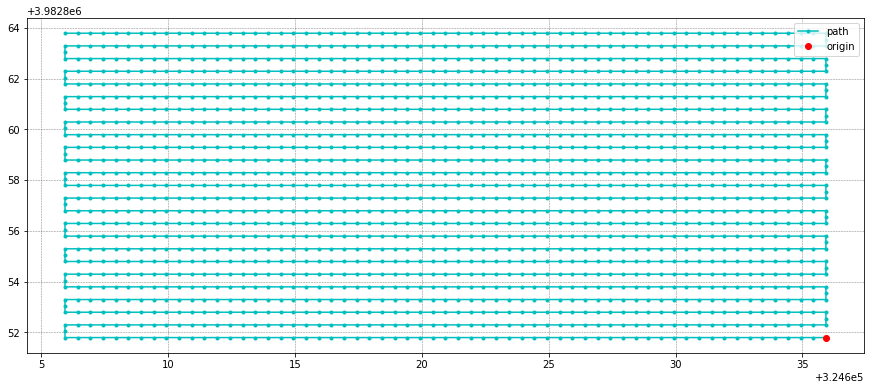

In [7]:
# Check result
fig, ax = plt.subplots(1,1, figsize = (15,15))
ax.plot(path_xy[:,0],path_xy[:,1],'-c.', label='path')
ax.plot(path_xy[:1,0],path_xy[:1,1],'ro', label='origin')
# ax.scatter([ori_xy[0]],[ori_xy[1]],marker='^', s=10, c='red', label='origin')
ax.grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.5)
ax.legend()
ax.set_aspect(1)

## 4) Convert utm to ll (ROV path)

In [8]:
mtrf2=Transformer.from_crs('epsg:32652','epsg:4326',always_xy=True) # UTM to LL
tmp=mtrf2.transform(path_xy[:,0],path_xy[:,1])
path_ll = np.hstack((tmp[0].reshape(-1,1),tmp[1].reshape(-1,1)))  # convert tuple to array

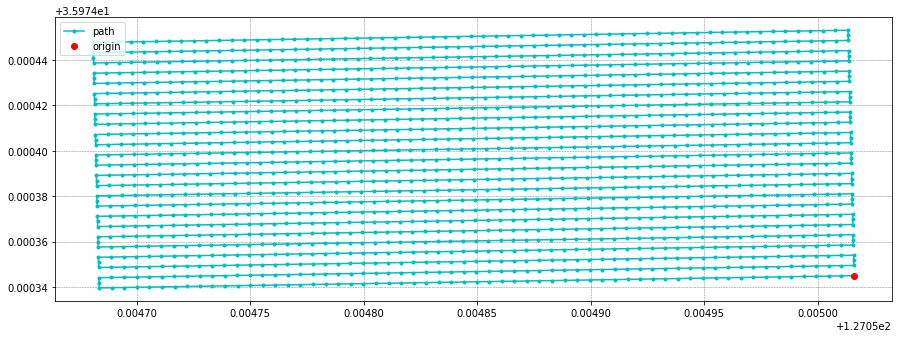

In [9]:
fig, ax = plt.subplots(1,1, figsize = (15,15))
ax.plot(path_ll[:,0],path_ll[:,1],'-c.', label='path')
ax.plot(path_ll[:1,0],path_ll[:1,1],'ro', label='origin')
# ax.scatter([ori_xy[0]],[ori_xy[1]],marker='^', s=10, c='red', label='origin')
ax.grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.5)
ax.legend()
ax.set_aspect(1)

## 5) Save file

In [10]:
out_file = 'path_ll.csv'
out_hdr='Lon(deg), Lat(deg)'
out_fmt= ['%13.8f','%12.8f']
np.savetxt(out_file,path_ll,delimiter=',',header=out_hdr,fmt=out_fmt)

In [11]:
out_file = 'path_xy.csv'
out_hdr='Easting(m), Northing(m)'
out_fmt= ['%10.2f','%11.2f']
np.savetxt(out_file,path_xy,delimiter=',',header=out_hdr,fmt=out_fmt)